In [78]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

import itertools

import warnings
warnings.filterwarnings('ignore')

In [79]:
class Normalizador:

  def fit(self, x):
    self.media = np.mean(x)
    self.std = np.std(x)

  def transform(self, x):
    return (x - self.media)/self.std

  def fit_transform(self, x):
    self.fit(x)
    return self.transform(x)

  def inverse_transform(self, x):
    return x*self.std + self.media

In [80]:
def divide_treino_teste(x, y, tamanho_treino=0.8):

    n = x.shape[0]
    q_treino = int(n * tamanho_treino)

    rng = np.random.default_rng()
    indices = rng.permutation(n)
    idx_treino = indices[:q_treino]
    idx_teste = indices[q_treino:]

    x_treino = x[idx_treino]
    x_teste = x[idx_teste]
    y_treino = y[idx_treino]
    y_teste = y[idx_teste]

    return x_treino, x_teste, y_treino, y_teste

## Implementa rede neural e função treino

In [81]:
class RedeNeural(nn.Module):
  def __init__(self, num_entrada, num_neuronios=16, num_classes=1):
    super().__init__()
    self.oculta = nn.Linear(num_entrada, num_neuronios)
    self.relu = nn.ReLU()
    self.saida = nn.Linear(num_neuronios, num_classes)

  def forward(self, x):
    x = self.oculta(x)
    x = self.relu(x)
    x = self.saida(x)
    return x


In [82]:
def treino_validacao(x_treino, y_treino, x_val, y_val, params, num_classes, num_entrada,problema='regressao', num_epochs=100, tamanho_batch=10):
    if problema == 'regressao':
        func_perda = nn.MSELoss
        y_treino = y_treino.float().view(-1,1)
        y_val = y_val.float().view(-1,1)
    elif problema == 'multiclass':
        func_perda = nn.CrossEntropyLoss
        y_treino = y_treino.long().view(-1)
        y_val = y_val.long().view(-1)

    comb_params = list(itertools.product(*params.values()))
    melhor_perda_val = float('inf')
    melhor_modelo = None
    melhor_params = None
    melhor_historico = None

    for lr, neuro_oculto, momentum in comb_params:
        print('---'*25)
        model = RedeNeural(num_entrada=num_entrada, num_neuronios=neuro_oculto, num_classes=num_classes)

        loss_fn = func_perda()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        historico_temp = {
            'train_loss': [],
            'val_loss': [],
        }

        for epoch in range(num_epochs):
            model.train()
            losses_epoca = []

            for i in range(0, len(x_treino), tamanho_batch):
                Xbatch = x_treino[i:i+tamanho_batch]
                ybatch = y_treino[i:i+tamanho_batch]
                y_pred = model(Xbatch)
                loss = loss_fn(y_pred, ybatch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses_epoca.append(loss.item())

            train_loss_epoca = np.mean(losses_epoca)

            model.eval()
            with torch.no_grad():
                y_val_pred = model(x_val)
                perda_val = loss_fn(y_val_pred, y_val).item()

                historico_temp['train_loss'].append(train_loss_epoca)
                historico_temp['val_loss'].append(perda_val)

                if problema == 'regressao':
                    print(f"[LR={lr:.4f}, Neurônios={neuro_oculto}, Momentum={momentum:.2f}] Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_epoca:.4f}, Val Loss: {perda_val:.4f}")

                else:
                    preds = torch.argmax(y_val_pred, dim=1)
                    acc_val = (preds == y_val).float().mean().item()
                    print(f"[LR={lr:.4f}, Neurônios={neuro_oculto}, Momentum={momentum:.2f}] Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_epoca:.4f}, Val Loss: {perda_val:.4f}, Val Acc: {acc_val:.4f}")

                if perda_val < melhor_perda_val:
                    melhor_perda_val = perda_val
                    melhor_modelo = model
                    melhor_params = (lr, neuro_oculto, momentum)
                    melhor_historico = historico_temp.copy()

    print(f"Melhor perda validação: {melhor_perda_val:.4f} com params LR={melhor_params[0]}, Neurônios={melhor_params[1]}, Momentum={melhor_params[2]}")
    return melhor_params, melhor_modelo, melhor_historico


In [83]:
def plotar_historicos_perda(historico, epochs, titulo='Função de custo no treino e validação para os melhores hiperparametros'):

  sns.lineplot(x=range(epochs), y=historico['train_loss'], label='Treino')
  sns.lineplot(x=range(epochs), y=historico['val_loss'], label='Validação')
  plt.title(titulo)
  plt.xlabel('Epochs')
  plt.ylabel('Função custo')
  plt.legend()
  plt.show()

In [84]:
def avaliar_modelo(modelo, x, y, problema='regressao', normalizador_y=None, conjunto=''):
    modelo.eval()
    with torch.no_grad():
        y_pred = modelo(x)

        if problema == 'regressao':

            y_pred = y_pred.numpy()
            y_true = y.numpy()

            y_pred_original = normalizador_y.inverse_transform(y_pred)
            y_true_original = normalizador_y.inverse_transform(y_true)
            rmse = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
            mae = mean_absolute_error(y_true_original, y_pred_original)
            mre = np.mean(np.abs((y_true_original - y_pred_original) / np.maximum(np.abs(y_true_original), 1e-8)))

            print(f"{conjunto}: RMSE: {rmse:.4f} - MAE: {mae:.4f} - MRE: {mre:.4f}")

        elif problema == 'multiclass':
            y_pred_classes = torch.argmax(y_pred, dim=1).numpy()
            y_true = y.numpy()

            acc = accuracy_score(y_true, y_pred_classes)

            print(f"{conjunto}: Acurácia: {acc:.4f}")

# Questão 1

In [85]:
dataset = pd.read_csv('https://raw.githubusercontent.com/PedroJoas/AprendizagemDeMaquina/refs/heads/main/listas/lista4/concrete.csv', header=None)
dataset.head()

,0,1,2,3,4,5,6,7,8
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0,44.30


In [86]:
params = {
    'lr':[0.001,0.0005],
    'neuronios_ocultos':[16,32],
    'momentums':[0.74,0.7,0.8]
}

In [87]:
X = dataset.iloc[:,:-1].to_numpy()
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
y = dataset.iloc[:,-1].to_numpy()

x_treino, x_teste, y_treino, y_teste = divide_treino_teste(X,y,tamanho_treino=0.6)

In [88]:
x_teste, x_val,y_teste,y_val = divide_treino_teste(x_teste,y_teste, tamanho_treino=0.5)

In [89]:
normalizador_x = Normalizador()
normalizador_y = Normalizador()
x_treino = normalizador_x.fit_transform(x_treino)
y_treino = normalizador_y.fit_transform(y_treino)

x_teste = normalizador_x.transform(x_teste)
x_val = normalizador_x.transform(x_val)
y_val = normalizador_y.transform(y_val)

In [90]:
x_treino = torch.tensor(x_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)

x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

x_teste = torch.tensor(x_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [91]:
print(x_treino.shape)
print(x_teste.shape)
print(x_val.shape)

torch.Size([618, 9])
torch.Size([206, 9])
torch.Size([206, 9])


In [92]:
num_epochs=1500

In [93]:
melhores_params, melhor_modelo, historico = treino_validacao(x_treino,y_treino,x_val,y_val, params, num_classes=1,num_entrada=X.shape[1], num_epochs=num_epochs, tamanho_batch=50)

A saída de streaming foi truncada nas últimas 5000 linhas.
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1005/1500, Train Loss: 0.3184, Val Loss: 0.2572
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1006/1500, Train Loss: 0.3182, Val Loss: 0.2571
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1007/1500, Train Loss: 0.3180, Val Loss: 0.2570
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1008/1500, Train Loss: 0.3179, Val Loss: 0.2569
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1009/1500, Train Loss: 0.3177, Val Loss: 0.2567
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1010/1500, Train Loss: 0.3176, Val Loss: 0.2566
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1011/1500, Train Loss: 0.3174, Val Loss: 0.2565
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1012/1500, Train Loss: 0.3172, Val Loss: 0.2564
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1013/1500, Train Loss: 0.3171, Val Loss: 0.2562
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1014/1500, Train Loss: 0.3169, Val Loss

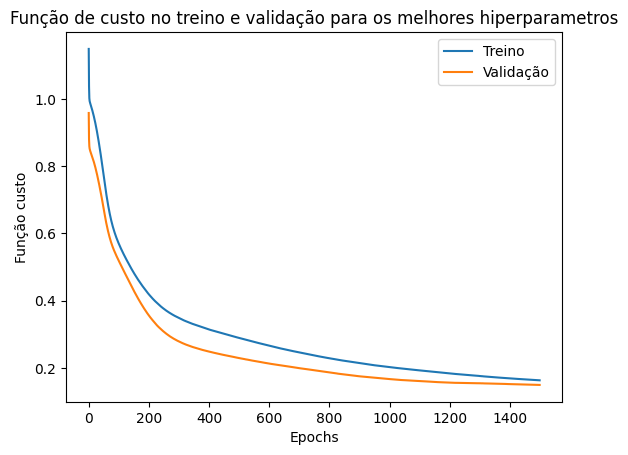

In [94]:
plotar_historicos_perda(historico, epochs=num_epochs)

In [95]:
print(f'Melhores parametros: lr:{melhores_params[0]}, Neurônios: {melhores_params[1]}, Momentum:{melhores_params[2]}')

avaliar_modelo(melhor_modelo, x_treino, y_treino, normalizador_y=normalizador_y, conjunto='Treino')
print('--'*20)
avaliar_modelo(melhor_modelo, x_val, y_val, normalizador_y=normalizador_y, conjunto='Validação')
print('--'*20)
avaliar_modelo(melhor_modelo, x_teste, y_teste, normalizador_y= normalizador_y, conjunto='Teste')

Melhores parametros: lr:0.001, Neurônios: 16, Momentum:0.8
Treino: RMSE: 6.9820 - MAE: 5.3227 - MRE: 0.7467
----------------------------------------
Validação: RMSE: 6.6954 - MAE: 5.1614 - MRE: 0.6856
----------------------------------------
Teste: RMSE: 655.5843 - MAE: 605.8549 - MRE: 0.9316


# Questão 2

In [96]:
vowels = pd.read_csv('https://raw.githubusercontent.com/PedroJoas/AprendizagemDeMaquina/refs/heads/main/listas/lista4/vowel.csv', header=None)
vowels.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,8.0
1,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,2.0
2,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,1.0
3,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,0.0
4,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,5.0


In [97]:
X = vowels.iloc[:,:-1].to_numpy()
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
y = vowels.iloc[:,-1].to_numpy()

x_treino, x_teste, y_treino, y_teste = divide_treino_teste(X,y,tamanho_treino=0.6)

In [98]:
x_teste, x_val,y_teste,y_val = divide_treino_teste(x_teste,y_teste, tamanho_treino=0.5)

In [99]:
normalizador_x = Normalizador()
normalizador_y = Normalizador()
x_treino = normalizador_x.fit_transform(x_treino)

x_teste = normalizador_x.transform(x_teste)
x_val = normalizador_x.transform(x_val)


In [100]:
x_treino = torch.tensor(x_treino, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
x_teste = torch.tensor(x_teste, dtype=torch.float32)

y_treino = torch.tensor(y_treino, dtype=torch.long).view(-1)
y_val = torch.tensor(y_val, dtype=torch.long).view(-1)
y_teste = torch.tensor(y_teste, dtype=torch.long).view(-1)


In [101]:
print(x_treino.shape)
print(x_teste.shape)
print(x_val.shape)

torch.Size([594, 11])
torch.Size([198, 11])
torch.Size([198, 11])


In [102]:
num_classes = vowels[10].unique().shape[0]

In [103]:
melhores_params, melhor_modelo, historico = treino_validacao(x_treino,y_treino,x_val,y_val, params, problema='multiclass',num_classes=num_classes,num_entrada=X.shape[1], num_epochs=num_epochs, tamanho_batch=50)

A saída de streaming foi truncada nas últimas 5000 linhas.
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1005/1500, Train Loss: 1.4748, Val Loss: 1.5475, Val Acc: 0.3788
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1006/1500, Train Loss: 1.4742, Val Loss: 1.5470, Val Acc: 0.3788
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1007/1500, Train Loss: 1.4735, Val Loss: 1.5464, Val Acc: 0.3788
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1008/1500, Train Loss: 1.4729, Val Loss: 1.5458, Val Acc: 0.3788
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1009/1500, Train Loss: 1.4722, Val Loss: 1.5452, Val Acc: 0.3788
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1010/1500, Train Loss: 1.4716, Val Loss: 1.5446, Val Acc: 0.3788
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1011/1500, Train Loss: 1.4709, Val Loss: 1.5440, Val Acc: 0.3737
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoch 1012/1500, Train Loss: 1.4702, Val Loss: 1.5434, Val Acc: 0.3737
[LR=0.0005, Neurônios=16, Momentum=0.80] Epoc

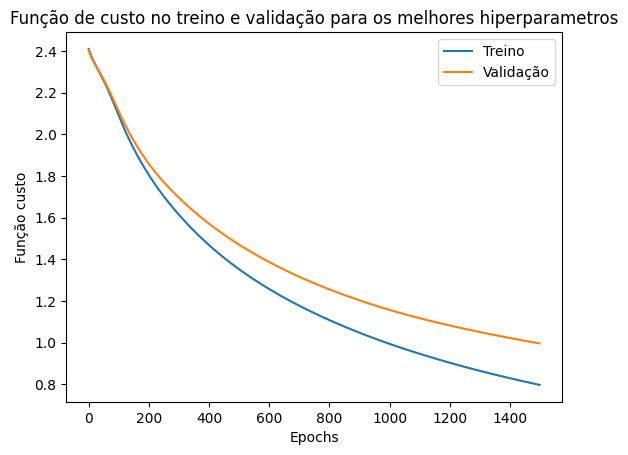

In [104]:
plotar_historicos_perda(historico, epochs=num_epochs)

In [105]:
print(f'Melhores parametros: lr:{melhores_params[0]}, Neurônios: {melhores_params[1]}, Momentum:{melhores_params[2]}')

avaliar_modelo(melhor_modelo, x_treino, y_treino, problema='multiclass', conjunto='Treino')
print('--'*20)
avaliar_modelo(melhor_modelo, x_val, y_val, problema='multiclass', conjunto='Validação')
print('--'*20)
avaliar_modelo(melhor_modelo, x_teste, y_teste, problema='multiclass', conjunto='Teste')

Melhores parametros: lr:0.001, Neurônios: 32, Momentum:0.8
Treino: Acurácia: 0.7407
----------------------------------------
Validação: Acurácia: 0.6263
----------------------------------------
Teste: Acurácia: 0.6970
